In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup
import re

抓股票代號

In [4]:
#抓美國市值前一百的股票代號
US100_stocks = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
    "scheme" : 'https',
    "path" : '/tw/image/Goodinfo.ico', 
    "Referer" : 'https://goodinfo.tw/tw/StockDetail.asp?STOCK_ID=0051',
    "Cookie" : 'CLIENT%5FID=20230920214311062%5F140%2E117%2E80%2E123; IS_TOUCH_DEVICE=F; SCREEN_SIZE=WIDTH=1920&HEIGHT=1080; TW_STOCK_BROWSE_LIST=0051'
}
response = requests.get("https://tw.tradingview.com/markets/stocks-usa/market-movers-large-cap/", headers=headers)

soup = BeautifulSoup(response.text, "html.parser")
stock_tags = soup.select('a[class="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat"][target="_blank"]')

for tag in stock_tags:
    US100_stocks.append(tag.text)

利用前面抓的股票代號來抓歷史股價 跟 美國十年期國債資料

In [7]:
#用yfinance隨機抓10隻美股股價
import yfinance as yf

random.seed(0)
US100_stocks = random.sample(US100_stocks, 10)

US100_stocks_prices = {}
for stock in US100_stocks:
    if stock == 'BRK.A':
        stock = 'BRK-A'
    prices = yf.Ticker(stock)
    historical_data = prices.history(start='2021-01-01', end='2022-12-31', period="1d")
    US100_stocks_prices[stock] = historical_data

In [19]:
ticker_symbol = "^TNX"  #十年期國債代號
us_10yr_bond = yf.Ticker(ticker_symbol)

TNX_10yr_yield_20212022 = {'TNX': us_10yr_bond.history(period="1d", start='2021-01-01', end='2022-12-31')}

In [20]:
TNX_10yr_yield_20212022

{'TNX':                             Open   High    Low  Close  Volume  Dividends  \
 Date                                                                       
 2021-01-04 00:00:00-05:00  0.935  0.953  0.907  0.917       0        0.0   
 2021-01-05 00:00:00-05:00  0.937  0.963  0.927  0.955       0        0.0   
 2021-01-06 00:00:00-05:00  1.000  1.054  1.000  1.042       0        0.0   
 2021-01-07 00:00:00-05:00  1.056  1.088  1.054  1.071       0        0.0   
 2021-01-08 00:00:00-05:00  1.088  1.126  1.075  1.105       0        0.0   
 ...                          ...    ...    ...    ...     ...        ...   
 2022-12-23 00:00:00-05:00  3.701  3.753  3.695  3.751       0        0.0   
 2022-12-27 00:00:00-05:00  3.787  3.862  3.787  3.860       0        0.0   
 2022-12-28 00:00:00-05:00  3.818  3.890  3.815  3.887       0        0.0   
 2022-12-29 00:00:00-05:00  3.868  3.886  3.818  3.835       0        0.0   
 2022-12-30 00:00:00-05:00  3.869  3.905  3.831  3.879       0       

利用股價生成日報酬

In [18]:
#將股價換算成日報酬率的函數
def get_stocks_returns(stocks_prices):
    stocks_daily_returns = {}
    for stock in stocks_prices:
        try:
            stock_daily_price = np.array(stocks_prices[stock]['Close']).astype(float)
        except:
            stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_daily_returns[stock] = np.diff(stock_daily_price) / stock_daily_price[:-1]
    return stocks_daily_returns

In [21]:
US100_stocks_returns = get_stocks_returns(US100_stocks_prices)
TNX_10yr_returns = get_stocks_returns(TNX_10yr_yield_20212022)

計算年化報酬

In [9]:
# #隨機生成波動率介於0.02~0.15的100組（股票）的收益率
# def random_returns():
#     days = 252
#     samples = 100
#     volatility = np.linspace(0.02, 0.15, 20)    # 每日收益率的標準差（波動率）

#     random_returns = []
#     for i in range(samples):
#         stock_return = np.random.normal(0, random.choice(volatility), days)
#         random_returns.append(stock_return)

#     return np.array(random_returns)

開始計算protfolio_variance

In [68]:
from collections import Counter

#將收益率陣列長度不等於最長天數的股票刪除
def returns_length_reshape(stocks_returns):
    length = []
    for stock in stocks_returns:
        length.append(len(stocks_returns[stock]))
    max_length = Counter(length).most_common(1)[0][0]
    to_del = []
    for stock in stocks_returns:
        if len(stocks_returns[stock]) != max_length:
            #print(f'{stock} 的收益率陣列長度只有 {len(stocks_returns[stock])} 天，不等於最長天數 {max_length}')
            to_del.append(stock)

    #刪除收益率陣列長度不等於最長天數的股票
    for stock in to_del:
        del stocks_returns[stock]

#透過日報酬計算個股標準差
def standard_deviation_matrix(stocks_returns):
    returns = dict(stocks_returns)
    stocks_std = []
    for stock in returns:
        stocks_std.append(np.std(returns[stock]))
    return np.diag(stocks_std)

#計算相關係數矩陣
def correlation_matrix(stocks_returns):
    temp_dict = dict(stocks_returns)     
    size = len(temp_dict)
    correlation_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(i+1, size):
            correlation = np.corrcoef(temp_dict[list(temp_dict.keys())[i]], temp_dict[list(temp_dict.keys())[j]])[0][1]
            correlation_matrix[i][j] = correlation
            correlation_matrix[j][i] = correlation
    np.fill_diagonal(correlation_matrix, 1)
    return correlation_matrix

#計算共變異數矩陣
def V_matrix(stocks_returns):
    V = np.dot(np.dot(standard_deviation_matrix(stocks_returns), correlation_matrix(stocks_returns)), standard_deviation_matrix(stocks_returns))
    return V

In [69]:
#先清理收益率陣列長度不等於最長天數的股票
returns_length_reshape(US100_stocks_returns)
returns_length_reshape(TW100_stocks_returns)
returns_length_reshape(ele100_stocks_returns)
returns_length_reshape(US100andTW100_stocks_returns)

In [12]:
# #隨機生成V
# def random_V(size):
#     matrix_size = size
#     symmetric_matrix = np.zeros((matrix_size, matrix_size))

#     for i in range(matrix_size):
#         for j in range(i + 1, matrix_size):
#             value = np.random.uniform(-1, 1)
#             symmetric_matrix[i, j] = value
#             symmetric_matrix[j, i] = -value  

#     np.fill_diagonal(symmetric_matrix, 1)

#     return symmetric_matrix

In [70]:
#計算有N個組成的投組的變異數
def get_variance_of_protfolio(V, N):
    avg_of_stocks_variance = np.sum(np.diag(V)) / N
    avg_of_stocks_covariance = np.sum([V[i, j] for i in range(min(V.shape)) for j in range(min(V.shape)) if i != j]) / (N * (N - 1) / 2)
    
    variance_of_protfolio = 1 / N * avg_of_stocks_variance + (N - 1) / N * avg_of_stocks_covariance
    # sd = np.sqrt(variance_of_protfolio)

    return variance_of_protfolio

In [71]:
#隨機選擇n個股票
def get_random_stocks(stocks_returns, n):
    temp_dict = dict(stocks_returns)
    
    if n >= len(temp_dict):
        return temp_dict
    else:
        keys = list(temp_dict.keys())
        random_keys = random.sample(keys, n)
        random_elements = {k: temp_dict[k] for k in random_keys}
        return random_elements

In [72]:
#將2~100檔股票組成的投組的變異數存入陣列
def arr_of_protfolio_variance(stocks_returns):
    arr_of_protfolio_variance = []
    repeats = 50
    for i in range(2,101):
        sd = 0
        for j in range(repeats):
            random_stocks = get_random_stocks(stocks_returns, i)
            V = V_matrix(random_stocks)
            sd += get_variance_of_protfolio(V, i)
        avg_sd = sd / repeats
        arr_of_protfolio_variance.append(avg_sd)
    return arr_of_protfolio_variance

In [94]:
def save(arr, fileName):
    with open(f'C:\\Users\\user\\Desktop\\MPTIS\\HW1\\{fileName}_dailyReturn.txt', 'w') as f:
        for item in arr:
            f.write((str(item) + '\n'))

def read(fileName):
    with open(f'C:\\Users\\user\\Desktop\\MPTIS\\HW1\\{fileName}_dailyReturn.txt', 'r') as f:
        arr = f.read().splitlines()
        arr = [float(i) for i in arr]
        return arr

In [95]:
# #因為計算時會取50次抽樣平均，運算時間可能會花30分鐘以上
# US100 = arr_of_protfolio_variance(US100_stocks_returns)
# TW100 = arr_of_protfolio_variance(TW100_stocks_returns)
# ele100 = arr_of_protfolio_variance(ele100_stocks_returns)
# US100andTW100 = arr_of_protfolio_variance(US100andTW100_stocks_returns)

# save(US100, 'US100')
# save(TW100, 'TW100')
# save(ele100, 'ele100')
# save(US100andTW100, 'US100andTW100')


#讀取上次存的txt檔案節省計算時間。 若要重算就把上面註解拿掉
US100 = read('US100')
TW100 = read('TW100')
ele100 = read('ele100')
US100andTW100 = read('US100andTW100')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


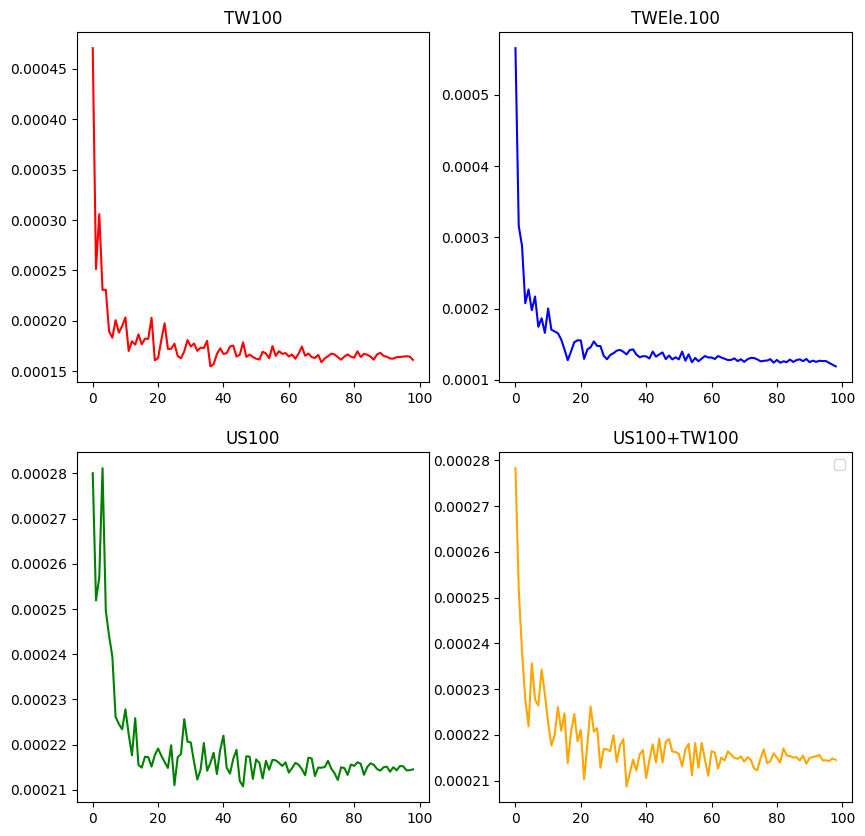

In [96]:
#plot 4x4 figure
plt.figure(figsize=(10, 10))

#第一張圖(TW100)
plt.subplot(2, 2, 1)
plt.title('TW100')
plt.plot([i for i in range(len(TW100))], TW100, label='TW100', color='red')

#第二張圖(ele100)
plt.subplot(2, 2, 2)
plt.title('TWEle.100')
plt.plot([i for i in range(len(ele100))], ele100, label='ele100', color='blue')

#第三張圖(US100)
plt.subplot(2, 2, 3)
plt.title('US100')
plt.plot([i for i in range(len(US100))], US100, label='US100', color='green')

#第四張圖(US100+TW100)
plt.subplot(2, 2, 4)
plt.title('US100+TW100')
plt.plot([i for i in range(len(US100andTW100))], US100andTW100, color='orange')

plt.legend()
plt.show()


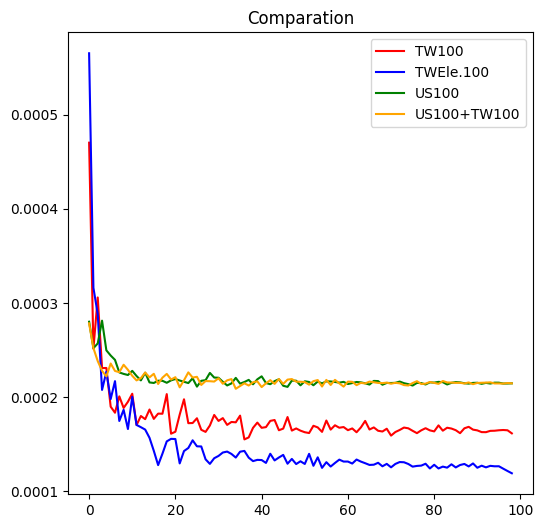

In [97]:
plt.figure(figsize=(6, 6))

plt.title('Comparation')
plt.plot([i for i in range(len(TW100))], TW100, label='TW100', color='red')
plt.plot([i for i in range(len(ele100))], ele100, label='TWEle.100', color='blue')
plt.plot([i for i in range(len(US100))], US100, label='US100', color='green')
plt.plot([i for i in range(len(US100andTW100))], US100andTW100, label='US100+TW100', color='orange')

plt.legend()
plt.show()